# Train Anomaly Detection Models (Unsupervised)

This notebook trains unsupervised models that learn ONLY from **BENIGN** traffic to detect zero-day attacks and anomalies.

**Models:**
- **Isolation Forest**: Fast, tree-based anomaly scoring.
- **Variational Autoencoder (VAE)**: Probabilistic deep learning model for robust anomaly detection.
- **Autoencoder (AE)**: Basic reconstruction-based detection.

**Process:**
1. Load BENIGN traffic from CIC-IDS-2017 and captured flows.
2. Preprocess (Scaling, Clipping).
3. Train models on Benign data only.
4. Determine anomaly thresholds (e.g., 95th percentile of reconstruction error).
5. Evaluate on mixed Benign/Attack data.
6. Save models for production use.

In [1]:

import numpy as np

WINDOW_SIZE = 5
SELECTED_FEATURES = ["Destination Port", "Min Packet Length", "Bwd Packet Length Min", "Init_Win_bytes_forward", "min_seg_size_forward", "Bwd Packet Length Mean", "Fwd Packet Length Min", "Avg Bwd Segment Size", "Bwd Packet Length Max", "Packet Length Std", "Bwd Packet Length Std", "Init_Win_bytes_backward", "Fwd Header Length.1", "Max Packet Length", "Packet Length Variance", "Average Packet Size", "Fwd IAT Mean", "Subflow Bwd Bytes", "Flow IAT Max", "Fwd Header Length"]

def create_sequences(data, window_size):
    # data: (N, F) array
    # returns: (N - window_size + 1, window_size * F) flattened
    X = []
    for i in range(len(data) - window_size + 1):
        window = data[i:(i + window_size)]
        X.append(window.flatten())
    return np.array(X)

print(f"Window Size: {WINDOW_SIZE}")
print(f"Selected Features: {len(SELECTED_FEATURES)}")


Window Size: 5
Selected Features: 20


## 1. Setup & Imports

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import joblib
import json
import time
import os

# ML imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc

# TensorFlow / Keras
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers, Model
    # Check GPU
    print(f"TensorFlow version: {tf.__version__}")
    print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")
except ImportError:
    print("TensorFlow not installed. Deep learning models will be skipped.")

# Plot settings
sns.set(style='darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print("\nAll imports successful!")

2026-01-05 16:22:26.511771: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.20.0
GPU Available: True

All imports successful!


## 2. Configuration

In [3]:
# Directories (Relative to notebooks folder)
DATA_DIR = Path('../data/cicids')
CAPTURED_DIR = Path('../data/captured/flows')
LABELED_DIR = Path('../data/labeled/flows')
MODELS_DIR = Path('../data/models')
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Training Configuration
SAMPLE_SIZE = 500000    # Number of benign samples to train on
RANDOM_STATE = 42

# VAE Config
LATENT_DIM = 32
BETA = 0.5
VAE_EPOCHS = 50         # Reduced for notebook speed, increase for production
BATCH_SIZE = 256
THRESHOLD_PCT = 80      # Percentile for anomaly threshold (95 = 5% false positive rate on training data)

print(f"Data Directory: {DATA_DIR}")
print(f"Models Directory: {MODELS_DIR}")

Data Directory: ../data/cicids
Models Directory: ../data/models


### Column Mapping
Standardize column names between CIC-IDS-2017 and `cicflowmeter` output.

In [4]:
# Complete column mapping: cicflowmeter format -> CIC-IDS-2017 format
# This maps lowercase/underscore column names to the CIC-IDS-2017 format used in training
COLUMN_MAP = {
    'flow_duration': 'Flow Duration',
    'dst_port': 'Destination Port',
    'destination_port': 'Destination Port',
    'flow_byts_s': 'Flow Bytes/s',
    'flow_pkts_s': 'Flow Packets/s',
    'fwd_pkts_s': 'Fwd Packets/s',
    'bwd_pkts_s': 'Bwd Packets/s',
    'tot_fwd_pkts': 'Total Fwd Packets',
    'tot_bwd_pkts': 'Total Backward Packets',
    'totlen_fwd_pkts': 'Total Length of Fwd Packets',
    'totlen_bwd_pkts': 'Total Length of Bwd Packets',
    'fwd_pkt_len_max': 'Fwd Packet Length Max',
    'fwd_pkt_len_min': 'Fwd Packet Length Min',
    'fwd_pkt_len_mean': 'Fwd Packet Length Mean',
    'fwd_pkt_len_std': 'Fwd Packet Length Std',
    'bwd_pkt_len_max': 'Bwd Packet Length Max',
    'bwd_pkt_len_min': 'Bwd Packet Length Min',
    'bwd_pkt_len_mean': 'Bwd Packet Length Mean',
    'bwd_pkt_len_std': 'Bwd Packet Length Std',
    'pkt_len_max': 'Max Packet Length',
    'pkt_len_min': 'Min Packet Length',
    'min_pkt_len': 'Min Packet Length',
    'pkt_len_mean': 'Packet Length Mean',
    'pkt_len_std': 'Packet Length Std',
    'pkt_len_var': 'Packet Length Variance',
    'flow_iat_mean': 'Flow IAT Mean',
    'flow_iat_std': 'Flow IAT Std',
    'flow_iat_max': 'Flow IAT Max',
    'flow_iat_min': 'Flow IAT Min',
    'fwd_iat_tot': 'Fwd IAT Total',
    'fwd_iat_mean': 'Fwd IAT Mean',
    'fwd_iat_std': 'Fwd IAT Std',
    'fwd_iat_max': 'Fwd IAT Max',
    'fwd_iat_min': 'Fwd IAT Min',
    'bwd_iat_tot': 'Bwd IAT Total',
    'bwd_iat_mean': 'Bwd IAT Mean',
    'bwd_iat_std': 'Bwd IAT Std',
    'bwd_iat_max': 'Bwd IAT Max',
    'bwd_iat_min': 'Bwd IAT Min',
    'fwd_psh_flags': 'Fwd PSH Flags',
    'bwd_psh_flags': 'Bwd PSH Flags',
    'fwd_urg_flags': 'Fwd URG Flags',
    'bwd_urg_flags': 'Bwd URG Flags',
    'fwd_header_len': 'Fwd Header Length',
    'bwd_header_len': 'Bwd Header Length',
    'fin_flag_cnt': 'FIN Flag Count',
    'syn_flag_cnt': 'SYN Flag Count',
    'rst_flag_cnt': 'RST Flag Count',
    'psh_flag_cnt': 'PSH Flag Count',
    'ack_flag_cnt': 'ACK Flag Count',
    'urg_flag_cnt': 'URG Flag Count',
    'ece_flag_cnt': 'ECE Flag Count',
    'cwr_flag_count': 'CWE Flag Count',
    'cwr_flag_cnt': 'CWE Flag Count',
    'down_up_ratio': 'Down/Up Ratio',
    'pkt_size_avg': 'Average Packet Size',
    'init_fwd_win_byts': 'Init_Win_bytes_forward',
    'init_bwd_win_byts': 'Init_Win_bytes_backward',
    'active_mean': 'Active Mean',
    'active_std': 'Active Std',
    'active_max': 'Active Max',
    'active_min': 'Active Min',
    'idle_mean': 'Idle Mean',
    'idle_std': 'Idle Std',
    'idle_max': 'Idle Max',
    'idle_min': 'Idle Min',
    'fwd_seg_size_avg': 'Avg Fwd Segment Size',
    'bwd_seg_size_avg': 'Avg Bwd Segment Size',
    'fwd_seg_size_min': 'min_seg_size_forward',
    'fwd_act_data_pkts': 'act_data_pkt_fwd',
    'subflow_fwd_pkts': 'Subflow Fwd Packets',
    'subflow_fwd_byts': 'Subflow Fwd Bytes',
    'subflow_bwd_pkts': 'Subflow Bwd Packets',
    'subflow_bwd_byts': 'Subflow Bwd Bytes',
}


## 3. Load Data

In [5]:
# Helper functions for column normalization and mapping
def normalize_columns(df):
    """Normalize column names: strip, lowercase, replace spaces with underscores."""
    df = df.copy()
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    return df

def map_columns_to_cicids(df):
    """Map cicflowmeter column names to CIC-IDS-2017 format."""
    df = df.copy()
    # First normalize to lowercase/underscore format
    df = normalize_columns(df)
    # Then map to CIC-IDS-2017 format (only map columns that exist)
    rename_dict = {k: v for k, v in COLUMN_MAP.items() if k in df.columns}
    df = df.rename(columns=rename_dict)
    return df

def get_feature_columns_only(df):
    """Extract only numeric feature columns, excluding metadata.
    
    Note: Destination Port and Source Port are FEATURES (numeric), not metadata.
    We only exclude IP addresses, protocol (if string), timestamps, and labels.
    """
    # Columns to exclude (non-feature metadata)
    # Be specific: only exclude IP addresses, not ports (ports are features!)
    exclude_patterns = [
        'source ip', 'destination ip', 'src_ip', 'dst_ip',  # IP addresses
        'protocol',  # Protocol (if string/categorical)
        'timestamp',  # Timestamps
        'label', 'attack type', 'attack number'  # Labels
    ]
    
    # Get numeric columns (this includes Destination Port, Source Port, etc.)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Filter out metadata columns (but keep ports - they're features!)
    feature_cols = [
        col for col in numeric_cols 
        if not any(pattern in col.lower() for pattern in exclude_patterns)
    ]
    
    return feature_cols

def align_columns(dfs_list, reference_columns=None, feature_only=True):
    """Ensure all DataFrames have the same columns before concatenation.
    
    Args:
        dfs_list: List of DataFrames to align
        reference_columns: Optional list of reference columns to use
        feature_only: If True, only align feature columns (exclude metadata)
    """
    if not dfs_list:
        return []
    
    # If feature_only, identify feature columns from all DataFrames
    if feature_only:
        all_feature_cols = set()
        for df in dfs_list:
            feature_cols = get_feature_columns_only(df)
            all_feature_cols.update(feature_cols)
        reference_columns = sorted(list(all_feature_cols))
        
        # Remove duplicate columns (same feature, different names)
        # Keep only the first occurrence of each unique feature
        seen_features = {}
        unique_cols = []
        for col in reference_columns:
            # Normalize column name for comparison (remove spaces, case-insensitive)
            col_normalized = col.lower().replace(' ', '_').replace('-', '_')
            if col_normalized not in seen_features:
                seen_features[col_normalized] = col
                unique_cols.append(col)
            # If duplicate found, prefer CIC-IDS-2017 format (with spaces/capitals)
            elif ' ' in col and ' ' not in seen_features[col_normalized]:
                # Replace with CIC-IDS-2017 format
                idx = unique_cols.index(seen_features[col_normalized])
                unique_cols[idx] = col
                seen_features[col_normalized] = col
        
        reference_columns = sorted(unique_cols)
        print(f"  Identified {len(reference_columns)} unique feature columns")
    elif reference_columns is None:
        # If no reference, use the union of all columns
        reference_columns = set(dfs_list[0].columns)
        for df in dfs_list[1:]:
            reference_columns = reference_columns.union(set(df.columns))
        reference_columns = sorted(list(reference_columns))
    
    aligned_dfs = []
    for df in dfs_list:
        df_aligned = df.copy()
        # Add missing columns with NaN
        for col in reference_columns:
            if col not in df_aligned.columns:
                df_aligned[col] = np.nan
        # Select only reference columns and in the same order
        df_aligned = df_aligned[reference_columns]
        aligned_dfs.append(df_aligned)
    
    return aligned_dfs

def load_data(label_filter='BENIGN'):
    """Load traffic data filtered by label (BENIGN or ATTACK)."""
    print(f"\nLoading {label_filter} traffic...")
    dfs = []
    
    # 1. Load from CIC-IDS-2017 Main Data (already in CIC-IDS-2017 format)
    if DATA_DIR.exists():
        for f in DATA_DIR.glob('*.csv'):
            try:
                df = pd.read_csv(f, low_memory=False)
                df.columns = df.columns.str.strip()  # Only strip, don't normalize
                
                if 'Label' in df.columns:
                    mask = df['Label'].str.upper().str.strip() == 'BENIGN'
                    filtered = df[mask] if label_filter == 'BENIGN' else df[~mask]
                    
                    if len(filtered) > 0:
                        dfs.append(filtered)
                        print(f"{f.name}: {len(filtered): ,} rows")
            except Exception as e:
                print(f"  Error loading {f.name}: {e}")

    # 2. Captured Data (Assumed Benign) - needs column mapping
    if label_filter == 'BENIGN' and CAPTURED_DIR.exists():
        for f in CAPTURED_DIR.glob('*.csv'):
            try:
                df = pd.read_csv(f, low_memory=False)
                # Map cicflowmeter format to CIC-IDS-2017 format
                df = map_columns_to_cicids(df)
                dfs.append(df)
                print(f"  {f.name}: {len(df):,} rows (Captured)")
            except Exception as e:
                print(f"  Error loading {f.name}: {e}")

    # 3. Custom Labeled Data - needs column mapping
    if LABELED_DIR.exists():
        for f in LABELED_DIR.glob('*.csv'):
            try:
                df = pd.read_csv(f, low_memory=False)
                # Map cicflowmeter format to CIC-IDS-2017 format
                df = map_columns_to_cicids(df)
                
                if 'Label' in df.columns:
                    is_benign = df['Label'].str.upper().str.strip() == 'BENIGN'
                    filtered = df[is_benign] if label_filter == 'BENIGN' else df[~is_benign]
                    
                    if len(filtered) > 0:
                        dfs.append(filtered)
                        print(f"  {f.name}: {len(filtered):,} rows (Custom)")
            except Exception as e:
                print(f"  Error loading {f.name}: {e}")

    if not dfs:
        print(f"No {label_filter} data found.")
        return None

    # Align columns before concatenation (feature columns only)
    print(f"\nAligning feature columns across {len(dfs)} DataFrames...")
    aligned_dfs = align_columns(dfs, feature_only=True)
    
    # Concatenate
    data = pd.concat(aligned_dfs, ignore_index=True)
    
    # Final cleanup: remove any remaining non-feature columns
    feature_cols = get_feature_columns_only(data)
    if len(feature_cols) < len(data.columns):
        excluded = [c for c in data.columns if c not in feature_cols]
        print(f"  Excluding {len(excluded)} non-feature columns: {excluded[:5]}{'...' if len(excluded) > 5 else ''}")
        data = data[feature_cols]
    
    # Remove columns that are mostly NaN (don't exist in most DataFrames)
    nan_threshold = 0.95  # If >95% NaN, remove column
    valid_cols = []
    removed_cols = []
    for col in data.columns:
        nan_pct = data[col].isna().sum() / len(data)
        if nan_pct < nan_threshold:
            valid_cols.append(col)
        else:
            removed_cols.append(col)
    
    if removed_cols:
        print(f"  Removing {len(removed_cols)} columns with >{nan_threshold*100:.0f}% NaN: {removed_cols[:5]}{'...' if len(removed_cols) > 5 else ''}")
        data = data[valid_cols]
    
    print(f"Total {label_filter} samples: {len(data):,}")
    print(f"Total feature columns: {len(data.columns)}")
    return data

In [6]:
# Load Benign Data for Training
df_benign = load_data('BENIGN')

# Sample if too large
if df_benign is not None and len(df_benign) > SAMPLE_SIZE:
    print(f"\nDownsampling from {len(df_benign):,} to {SAMPLE_SIZE:,} samples...")
    df_benign = df_benign.sample(SAMPLE_SIZE, random_state=RANDOM_STATE)
    
print(f"Training Data Shape: {df_benign.shape}")


Loading BENIGN traffic...
Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv:  168,186 rows
Tuesday-WorkingHours.pcap_ISCX.csv:  432,074 rows
Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv:  288,566 rows
Monday-WorkingHours.pcap_ISCX.csv:  529,918 rows
Wednesday-workingHours.pcap_ISCX.csv:  440,031 rows
Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv:  127,537 rows
Friday-WorkingHours-Morning.pcap_ISCX.csv:  189,067 rows
Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv:  97,718 rows
  capture_20260103_140151_flows.csv: 3 rows (Captured)
  capture_20260103_140130_flows.csv: 2 rows (Captured)
  capture_20260103_140110_flows.csv: 2 rows (Captured)
  capture_20260105_160232_flows.csv: 1 rows (Captured)

Aligning feature columns across 12 DataFrames...
  Identified 85 unique feature columns
  Removing 7 columns with >95% NaN: ['bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_pkts_b_avg', 'fwd_blk_rate_avg', 'fwd_byts_b_avg']...
Total BENIGN samples: 2,273,105
Total feature 

## 4. Preprocessing

In [7]:

def preprocess(df):
    global SELECTED_FEATURES
    
    # 1. Align Columns (Existing Logic)
    df = align_columns([df])[0]
    
    # 2. Select Features
    # Handle duplicates like 'Fwd Header Length.1' if they exist, or fallback
    missing = [c for c in SELECTED_FEATURES if c not in df.columns]
    if missing:
        print(f"Warning: Missing features: {missing}")
        # Try to fill 0 for missing to keep input shape consistent
        for c in missing:
            df[c] = 0
            
    df = df[SELECTED_FEATURES]
    
    # 3. Log Transform (Apply to all selected features to be safe, or just skewed ones)
    # Simple strategy: Log transform all > 0 values to compress range
    # Or stick to specific list if we knew them. Given dynamic selection, let's just log1p everything 
    # that is strictly positive and large? Or just standard scaler.
    # The previous code had a specific list. Let's keep it simple: StandardScaling is often enough if we select features well.
    # But let's apply log1p to everything for robust handling of network stats.
    for col in df.columns:
        if df[col].max() > 100: # Heuristic
             df[col] = np.log1p(df[col])
             
    # Handle Infinity/NaN
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    
    return df, df.columns


In [8]:
# Prepare Training Data
print("Preprocessing training data...")
X_train_raw, feature_cols = preprocess(df_benign)

# Scale Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)

# Create Sequences (Windowing)
print(f"Applying windowing (Size={WINDOW_SIZE})...")
X_train = create_sequences(X_train_scaled, WINDOW_SIZE)

print(f"Final Training Shape: {X_train.shape}")

Preprocessing training data...
  Identified 78 unique feature columns
Applying windowing (Size=5)...
Final Training Shape: (209597, 100)


## 5. Model 1: Isolation Forest
An unsupervised algorithm that isolates anomalies rather than profiling normal points.

In [9]:
print("Training Isolation Forest...")
iforest = IsolationForest(
    n_estimators=200,
    contamination=0.01,  # Estimate ~1% expected anomalies in data
    max_samples='auto',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

iforest.fit(X_train)
print("Done.")

Training Isolation Forest...
Done.


## 6. Model 2: Variational Autoencoder (VAE)
A deep generative model that learns the probability distribution of benign traffic. Anomalies (e.g., zero-day attacks) will have high reconstruction error.

In [10]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def get_config(self):
        return super().get_config()

In [11]:
def build_vae(input_dim, latent_dim=16, beta=1.0):
    # --- Encoder ---
    enc_in = keras.Input(shape=(input_dim,))
    x = layers.Dense(128, activation='relu')(enc_in)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(32, activation='relu')(x)
    
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    z = Sampling()([z_mean, z_log_var])
    
    encoder = Model(enc_in, [z_mean, z_log_var, z], name='encoder')
    
    # --- Decoder ---
    dec_in = keras.Input(shape=(latent_dim,))
    x = layers.Dense(32, activation='relu')(dec_in)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation='relu')(x)
    dec_out = layers.Dense(input_dim)(x)
    
    decoder = Model(dec_in, dec_out, name='decoder')
    
    # --- VAE Class ---
    class VAE(Model):
        def __init__(self, encoder, decoder, beta=1.0):
            super().__init__()
            self.encoder = encoder
            self.decoder = decoder
            self.beta = beta
            self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
            self.content_loss_tracker = keras.metrics.Mean(name="content_loss")
            self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

        @property
        def metrics(self):
            return [
                self.total_loss_tracker,
                self.content_loss_tracker,
                self.kl_loss_tracker,
            ]

        def train_step(self, data):
            with tf.GradientTape() as tape:
                z_mean, z_log_var, z = self.encoder(data)
                reconstruction = self.decoder(z)
                
                # Losses
                reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data - reconstruction), axis=1))
                kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
                kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
                total_loss = reconstruction_loss + (self.beta * kl_loss)

            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            
            self.total_loss_tracker.update_state(total_loss)
            self.content_loss_tracker.update_state(reconstruction_loss)
            self.kl_loss_tracker.update_state(kl_loss)
            return {
                "loss": self.total_loss_tracker.result(),
                "content_loss": self.content_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result(),
            }
            
        def call(self, x):
            _, _, z = self.encoder(x)
            return self.decoder(z)
            
    vae = VAE(encoder, decoder, beta=beta)
    vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
    
    return vae, encoder, decoder

Building VAE (Latent Dim=32, Beta=0.5)...


I0000 00:00:1767604997.150894   11697 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2554 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Training VAE...
Epoch 1/50


2026-01-05 16:23:22.841237: I external/local_xla/xla/service/service.cc:163] XLA service 0x7fe774005fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-05 16:23:22.841268: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2026-01-05 16:23:22.947990: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-05 16:23:23.616804: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


 46/819 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - content_loss: 103.0260 - kl_loss: 2.2054 - loss: 104.1287

I0000 00:00:1767605006.677113   11831 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - content_loss: 48.6057 - kl_loss: 12.0304 - loss: 54.6208 - learning_rate: 0.0010
Epoch 2/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - content_loss: 27.0678 - kl_loss: 13.1713 - loss: 33.6535 - learning_rate: 0.0010
Epoch 3/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - content_loss: 23.5813 - kl_loss: 13.9909 - loss: 30.5768 - learning_rate: 0.0010
Epoch 4/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - content_loss: 21.7501 - kl_loss: 14.5027 - loss: 29.0015 - learning_rate: 0.0010
Epoch 5/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - content_loss: 20.4500 - kl_loss: 14.8389 - loss: 27.8695 - learning_rate: 0.0010
Epoch 6/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - content_loss: 19.2583 - kl_loss: 15.1529 - loss: 26.8348 - learning_rate: 0.0010
Epoch 7/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - content_loss: 18.2951 - kl_loss: 15.4788 - loss: 26.0345 - learning_rate: 0.0010
Epoch 8/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - content_los

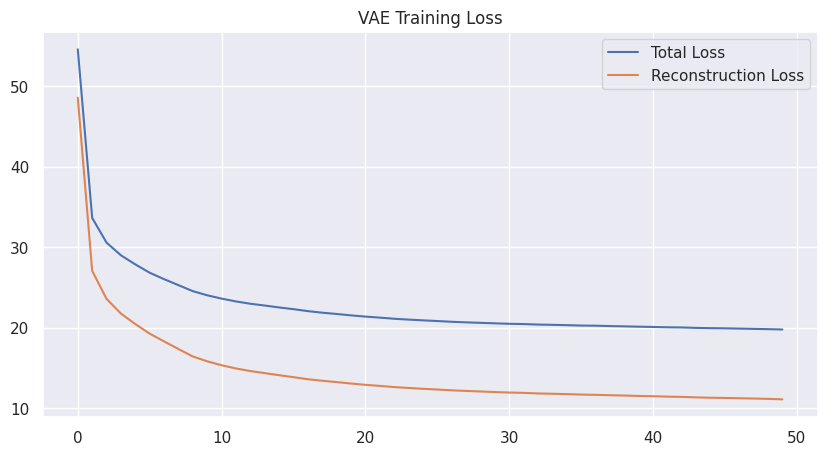

In [12]:
print(f"Building VAE (Latent Dim={LATENT_DIM}, Beta={BETA})...")
vae, encoder, decoder = build_vae(input_dim=X_train.shape[1], latent_dim=LATENT_DIM, beta=BETA)

callbacks = [
    keras.callbacks.EarlyStopping(monitor='total_loss' if hasattr(vae, 'total_loss_tracker') else 'loss', 
                                  patience=10, restore_best_weights=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(monitor='total_loss' if hasattr(vae, 'total_loss_tracker') else 'loss', 
                                      factor=0.5, patience=5, min_lr=1e-6, mode='min')
]

print("Training VAE...")
history = vae.fit(X_train, epochs=VAE_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, verbose=1)

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Total Loss')
if 'content_loss' in history.history:
    plt.plot(history.history['content_loss'], label='Reconstruction Loss')
plt.title('VAE Training Loss')
plt.legend()
plt.show()

Calculating reconstruction error...
6550/6550 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
6550/6550 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step

VAE Threshold (80th percentile): 0.147045
Max MSE: 1.624211, Mean MSE: 0.110503


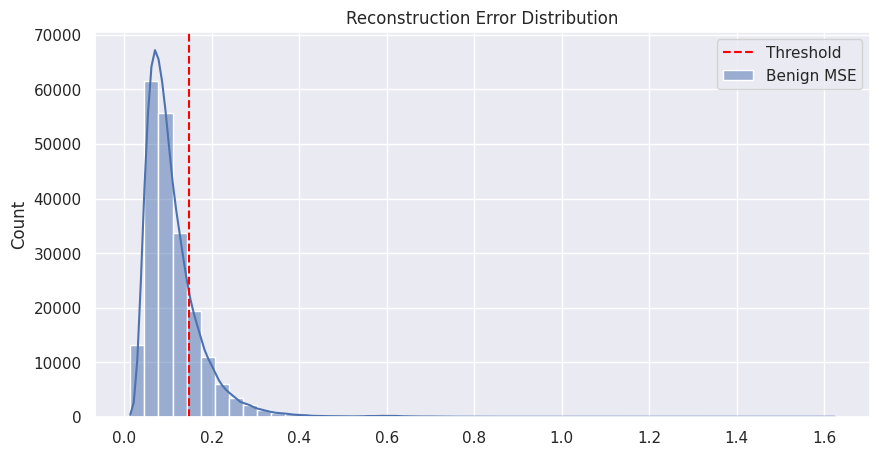

In [19]:
# Determine Threshold
print("Calculating reconstruction error...")
z_mean, _, z = encoder.predict(X_train)
recon = decoder.predict(z)
mse = np.mean(np.square(X_train - recon), axis=1)

threshold = np.percentile(mse, THRESHOLD_PCT)
print(f"\nVAE Threshold ({THRESHOLD_PCT}th percentile): {threshold:.6f}")
print(f"Max MSE: {np.max(mse):.6f}, Mean MSE: {np.mean(mse):.6f}")

# Hist plot
plt.figure(figsize=(10, 5))
sns.histplot(mse, bins=50, kde=True, label='Benign MSE')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.title('Reconstruction Error Distribution')
plt.legend()
plt.show()

## 7. Evaluation
Test on mixed data (attack + benign) to evaluate detection performance.

In [20]:
df_attack = load_data('ATTACK')

if df_attack is not None:
    print("\nProcessing Attack Data...")
    X_attack_raw, _ = preprocess(df_attack) # unpack tuple, ignore log_cols (same as train)
    X_attack = scaler.transform(X_attack_raw)
    X_attack = create_sequences(X_attack, WINDOW_SIZE)
    
    # Create Eval Set (Mixed)
    n_test = min(len(X_attack), 5000)
    X_test_att = X_attack[:n_test]
    X_test_ben = X_train[:n_test] # Use seen benign for convenience, or holdout
    
    X_eval = np.concatenate([X_test_ben, X_test_att])
    y_eval = np.array([0]*len(X_test_ben) + [1]*len(X_test_att))
    
    # --- Eval VAE ---
    print("\n--- VAE Evaluation ---")
    enc_z_mean, _, enc_z = encoder.predict(X_eval)
    pred_recon = decoder.predict(enc_z)
    pred_mse = np.mean(np.square(X_eval - pred_recon), axis=1)
    y_pred_vae = (pred_mse > threshold).astype(int)
    
    print(f"VAE Threshold used: {threshold:.6f} ({THRESHOLD_PCT}th percentile)")
    print(classification_report(y_eval, y_pred_vae, target_names=['Benign', 'Anomaly']))
    
    # --- Eval IForest ---
    print("\n--- Isolation Forest Evaluation ---")
    # IForest predicts -1 for anomaly, 1 for normal
    if_pred = iforest.predict(X_eval)
    y_pred_if = np.where(if_pred == -1, 1, 0)
    
    print(classification_report(y_eval, y_pred_if, target_names=['Benign', 'Anomaly']))


Loading ATTACK traffic...
Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv:  2,180 rows
Tuesday-WorkingHours.pcap_ISCX.csv:  13,835 rows
Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv:  36 rows
Wednesday-workingHours.pcap_ISCX.csv:  252,672 rows
Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv:  158,930 rows
Friday-WorkingHours-Morning.pcap_ISCX.csv:  1,966 rows
Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv:  128,027 rows

Aligning feature columns across 7 DataFrames...
  Identified 78 unique feature columns
Total ATTACK samples: 557,646
Total feature columns: 78

Processing Attack Data...
  Identified 78 unique feature columns

--- VAE Evaluation ---
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
VAE Threshold used: 0.147045 (80th percentile)
              precision    recall  f1-score   support

      Benign       1.00      0.80      0.89      5000
     Anomaly       0.83      1.00      0.91      5000

    accuracy        


Visualizing Error Distributions...


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


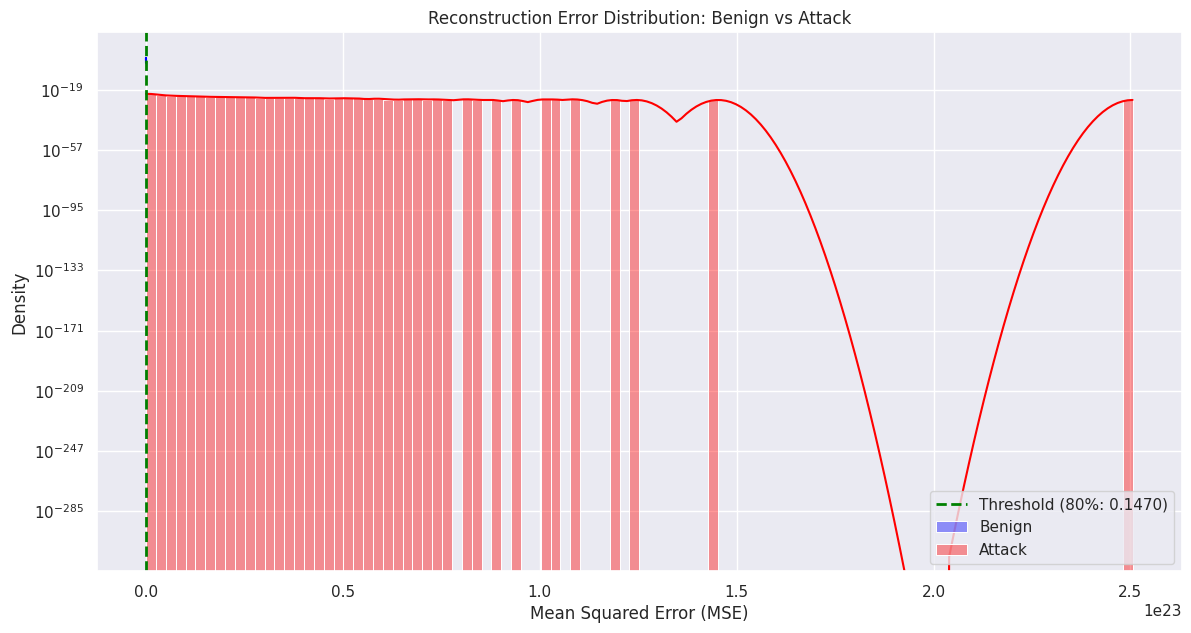

Benign Mean MSE: 0.1115, Std: 0.0678
Attack Mean MSE: 2838500210752593854464.0000, Std: 8068502323250226790400.0000


In [21]:
# Visualization: Benign vs Attack Reconstruction Error
print("\nVisualizing Error Distributions...")

# Re-calculate or sample for plot
n_samples = 10000
# Benign
X_benign_sample = X_train[:n_samples]
_, _, z_ben = encoder.predict(X_benign_sample)
recon_ben = decoder.predict(z_ben)
mse_ben = np.mean(np.square(X_benign_sample - recon_ben), axis=1)

# Attack (loaded in previous cell)
if 'X_attack' in locals() and X_attack is not None:
    X_att_sample = X_attack[:n_samples]
    _, _, z_att = encoder.predict(X_att_sample)
    recon_att = decoder.predict(z_att)
    mse_att = np.mean(np.square(X_att_sample - recon_att), axis=1)

    plt.figure(figsize=(14, 7))
    # Use log scale for Y axis if density varies significantly
    sns.histplot(mse_ben, bins=100, kde=True, color='blue', label='Benign', stat='density', alpha=0.4)
    sns.histplot(mse_att, bins=100, kde=True, color='red', label='Attack', stat='density', alpha=0.4)
    plt.axvline(threshold, color='green', linestyle='--', linewidth=2, label=f'Threshold ({THRESHOLD_PCT}%: {threshold:.4f})')
    plt.title('Reconstruction Error Distribution: Benign vs Attack')
    plt.xlabel('Mean Squared Error (MSE)')
    plt.legend()
    plt.yscale('log')
    plt.show()
    
    print(f"Benign Mean MSE: {np.mean(mse_ben):.4f}, Std: {np.std(mse_ben):.4f}")
    print(f"Attack Mean MSE: {np.mean(mse_att):.4f}, Std: {np.std(mse_att):.4f}")
else:
    print("X_attack not found. Did you run the Evaluation cell?")

## 8. Save Models

In [22]:
ts = datetime.now().strftime('%Y%m%d_%H%M%S')

# Save VAE
encoder.save(MODELS_DIR / f'vae_encoder_{ts}.keras')
decoder.save(MODELS_DIR / f'vae_decoder_{ts}.keras')
encoder.save(MODELS_DIR / 'vae_encoder_latest.keras')
decoder.save(MODELS_DIR / 'vae_decoder_latest.keras')

# Save Metadata (Scaler, Hist stats which are needed for threshold)
vae_meta = {
    'feature_columns': feature_cols,
    'log_columns': [],
    'scaler': scaler,
    'latent_dim': LATENT_DIM,
    'beta': BETA,
    'threshold': float(threshold),
    'threshold_pct': THRESHOLD_PCT,
    'encoder_path': str(MODELS_DIR / 'vae_encoder_latest.keras'),
    'decoder_path': str(MODELS_DIR / 'vae_decoder_latest.keras')
}
joblib.dump(vae_meta, MODELS_DIR / 'vae_meta_latest.pkl')
print(f"Saved VAE and Metadata.")

# Save IForest as Dict with metadata
iforest_data = {
    'model': iforest,
    'scaler': scaler,
    'feature_columns': feature_cols,
    'log_columns': [],
    'threshold': float(threshold) # Using VAE threshold reference or just dummy if iforest has its own
}
# Note: IForest internal threshold is decision_function related, but we save the object.
# The `layers.py` expects a dict with 'model' key.

joblib.dump(iforest_data, MODELS_DIR / f'isolation_forest_{ts}.pkl')
joblib.dump(iforest_data, MODELS_DIR / 'isolation_forest_latest.pkl')
print(f"Saved Isolation Forest (Dict format).")

Saved VAE and Metadata.
Saved Isolation Forest (Dict format).
